In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import time
import sys
import pytorch_model_summary
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm


print(f'torch : {torch.__version__}')
print(f'python : {sys.version}')

torch : 1.11.0
python : 3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0]


In [12]:

class ImageData(Dataset):
    def __init__(self,path,transform=None,target_transform=None):
        self.path = path
        self.files =[]
        self.labels = []
        for i in os.listdir(path):
            if i[:-3]+'png' in os.listdir(path+'/label'):
                self.files.append(i)
                self.labels.append(i[:-3]+'png')
        self.transform = transform
        self.target_transform = target_transform
        
    def __getitem__(self,idx):
        img = Image.open(self.path+'/'+self.files[idx])
        label = Image.open(self.path+'/label/'+self.labels[idx])
        #img = np.array(img)[:,:256]
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            label = self.target_transform(label)
        return img, label

    def __len__(self):
        return len(self.files)

class ConvertToBackground(object):
    def __call__(self, img):
        img = np.asarray(img,dtype=np.uint8)
        img[img==255] = 0
        # 64bit 부호 정수 long 타입 Tensor로 변환 
        img = torch.from_numpy(img).long()
        return img


In [13]:
data_mean = [0.485, 0.456, 0.406]
data_std = [0.229, 0.224, 0.225]

transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        #transforms.RandomHorizontalFlip(),
        #transforms.RandomCrop((224,224)),
        #transforms.RandomAffine(degrees=15),
        # PIL 타입의 [0,255] data를 [0,1]의 FloatTensor로 변환
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
val_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=data_mean,std=data_std)
    ]
)
label_transform = transforms.Compose(
    [
        transforms.Resize((224,224)),
        # 경계를 배경으로 처리
        ConvertToBackground()
    ]
)

batch_size = 4
train_path = './data/train'
train_set = ImageData(train_path,transform,label_transform)
#train_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='train',download=False,transform=transform,target_transform=label_transform)
train_loader = DataLoader(train_set, batch_size= batch_size,shuffle=True)
val_path = './data/val'
val_set = ImageData(val_path,val_transform,label_transform)
#val_set = torchvision.datasets.VOCSegmentation(root='./data', year='2012',\
#    image_set='val',download=False,transform=transform,target_transform=label_transform)
val_loader = DataLoader(val_set, batch_size= batch_size,shuffle=True)


In [14]:
#a,b = train_set[0]
#print(a.shape)

print(len(train_loader))
#temp_img,temp_label = next(iter(train_loader))
#print(temp_img)

366


In [15]:
# 사전에 학습된 vgg16 parameter 가져오기
vgg16 = torchvision.models.vgg16(pretrained=True)
#for param in vgg16.features.parameters():
#   param.requires_grad = False

In [16]:
class FCN32(nn.Module):
    # vgg 16 
    def __init__(self,num_class):
        super(FCN32, self).__init__()
        self.vgg16 = vgg16.features
        # self.conv1 = self.make_block(in_channel=3, out_channel=64,repeat=2)
        # self.conv2 = self.make_block(in_channel=64,out_channel=128,repeat=2)
        # self.conv3 = self.make_block(128,256,3)
        # self.conv4 = self.make_block(256,512,3)
        # self.conv5 = self.make_block(512,512,3)

        self.fc1 = nn.Conv2d(in_channels=512,out_channels=4096,kernel_size=1)
        self.fc2 = nn.Conv2d(4096,4096,kernel_size=1)
        self.fc3 = nn.Conv2d(4096,num_class,kernel_size=1)

        self.upsample32 = nn.ConvTranspose2d(in_channels=num_class,out_channels=num_class,kernel_size=32,stride=32,bias=False)
        #self.upsample32 = nn.Upsample(scale_factor=32,mode='bilinear')
        #self._initialize_weights()

    def forward(self, x):

        x = self.vgg16(x)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        x = nn.Dropout2d(0.5)(x)
        x = self.fc2(x)
        x = nn.ReLU()(x)
        x = nn.Dropout2d(0.5)(x)
        x = self.fc3(x)
        x = self.upsample32(x)
        #print(x.shape)
        return x
        

    # def _initialize_weights(self):
    #     for m in self.modules():
    #         print(m)
    #         if isinstance(m, nn.Conv2d):
    #             m.weight.data.zero_()
    #             if m.bias is not None:
    #                 m.bias.data.zero_()
    # def make_block(self, in_channel, out_channel, repeat):
    #     layers = []
    #     for i in range(repeat):
    #         if (i==0):
    #             layers.append(nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1, stride=1))
    #         else:
    #             layers.append(nn.Conv2d(out_channel,out_channel,kernel_size=3, padding=1, stride=1))
    #         layers.append(nn.BatchNorm2d(out_channel))
    #         layers.append(nn.ReLU())
    #     layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    #     block = nn.Sequential(*layers)

    #     return block

In [17]:
FCN =FCN32(num_class=21)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
#print(FCN)
print(pytorch_model_summary.summary(FCN,torch.zeros(batch_size,3,224,224),show_input=True))

Using cuda device
-----------------------------------------------------------------------------
         Layer (type)            Input Shape         Param #     Tr. Param #
             Conv2d-1       [4, 3, 224, 224]           1,792           1,792
               ReLU-2      [4, 64, 224, 224]               0               0
             Conv2d-3      [4, 64, 224, 224]          36,928          36,928
               ReLU-4      [4, 64, 224, 224]               0               0
          MaxPool2d-5      [4, 64, 224, 224]               0               0
             Conv2d-6      [4, 64, 112, 112]          73,856          73,856
               ReLU-7     [4, 128, 112, 112]               0               0
             Conv2d-8     [4, 128, 112, 112]         147,584         147,584
               ReLU-9     [4, 128, 112, 112]               0               0
         MaxPool2d-10     [4, 128, 112, 112]               0               0
            Conv2d-11       [4, 128, 56, 56]         295,

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(FCN.parameters(), lr=0.0001)

In [19]:
def pixel_accuracy(output, label):
    with torch.no_grad():
        output = torch.argmax(F.softmax(output, dim=1),dim=1)
        correct = torch.eq(output, label).int()
        accuracy = float(correct.sum()) / float(correct.numel())
    return accuracy
# https://sanghyu.tistory.com/3 -- view, contiguous
def mIoU(output, label,num_classes=21):
    with torch.no_grad():
        output = F.softmax(output, dim=1)
        output = torch.argmax(output, dim=1)
        # 메모리에 저장된 순서를 하나씩, view할때 섞이지 않도록
        output = output.contiguous().view(-1)
        label = label.contiguous().view(-1)
    
        iou_class = []
        for c in range(0, num_classes):
            output_true = output==c
            label_true = label==c

            if label_true.long().sum().item() == 0:
                iou_class.append(np.nan)
            else:
                intersect = torch.logical_and(output_true,label_true).sum().float().item()
                union = torch.logical_or(output_true,label_true).sum().float().item()
                iou= intersect/union
                iou_class.append(iou)
        return np.nanmean(iou_class)

def get_lr(optim):
    for param_group in optim.param_groups:
        return param_group['lr']

In [20]:
# 학습
FCN.to(device)
epochs= 50
best_loss = 0
train_loss_list = []
train_acc_list = []
train_iou_list = []
val_loss_list = []
val_acc_list = []
val_iou_list = []
min_miou = 0
lrs = []
for epoch in range(epochs):
    val_running_loss = 0
    train_running_loss =0
    start_time = time.time()
    train_iou_score = 0
    val_iou_score =0
    train_acc = 0
    val_acc = 0

    FCN.train()
    for iter,data in tqdm(enumerate(train_loader)):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = FCN(inputs)
        # print(f'input shape : {inputs.shape}')
        # print(f'output shape : {outputs[0][0].shape}')
        # print(f'output  --{outputs[0][0]}')
        # print(f'labels shape : {labels.shape}')
        # print(f'lable --{labels[labels>0]}')
        loss = criterion(outputs,labels) 
        loss.backward()
        optimizer.step()

        train_iou_score += mIoU(outputs, labels)
        train_acc += pixel_accuracy(outputs, labels)
        train_running_loss += loss.item()
    
    FCN.eval()
    with torch.no_grad():
        for iter, vdata in tqdm(enumerate(val_loader)):
            vinputs, vlabels = vdata
            vinputs = vinputs.to(device)
            vlabels = vlabels.to(device)

            voutputs = FCN(vinputs)
            vloss = criterion(voutputs,vlabels)

            val_running_loss += vloss.item()
            val_iou_score += mIoU(voutputs,vlabels)
            val_acc += pixel_accuracy(voutputs,vlabels)


        train_running_loss /= len(train_loader)
        train_iou_score /=len(train_loader)
        train_acc /=len(train_loader)
        val_running_loss /= len(val_loader)
        val_iou_score /=len(val_loader)
        val_acc /=len(val_loader)
        lrs.append(get_lr(optimizer))

        print(f'{epoch+1} epcoh , time = {time.time()-start_time:.2f}')
        print(f'train loss : {train_running_loss:.5f}, val_loss : {val_running_loss:.5f}')
        print(f'train IoU : {train_iou_score:.5f}, val IoU : {val_iou_score:.5f}')
        print(f'train Acc : {train_acc:.5f}, val Acc : {val_acc:.5f}')
        train_loss_list.append(train_running_loss)
        train_iou_list.append(train_iou_score)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_running_loss)
        val_iou_list.append(val_iou_score)
        val_acc_list.append(val_acc)

        if min_miou < val_iou_score:
            min_miou = val_iou_score
            #print('save model')
            torch.save(FCN, './models/FCN32-Vgg16_test.pt') 
            
                   
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list, 'lr':lrs}
print('Finish Training')

366it [00:28, 12.72it/s]
363it [00:18, 19.56it/s]


1 epcoh , time = 47.33
train loss : 1.22772, val_loss : 1.04025
train IoU : 0.12731, val IoU : 0.15404
train Acc : 0.72486, val Acc : 0.75514


366it [00:28, 12.76it/s]
363it [00:18, 19.81it/s]


2 epcoh , time = 47.00
train loss : 0.95317, val_loss : 0.92085
train IoU : 0.17620, val IoU : 0.22163
train Acc : 0.76299, val Acc : 0.77587


366it [00:28, 12.89it/s]
363it [00:18, 19.51it/s]


3 epcoh , time = 47.00
train loss : 0.80873, val_loss : 0.84091
train IoU : 0.21725, val IoU : 0.21549
train Acc : 0.78059, val Acc : 0.77054


366it [00:28, 12.88it/s]
363it [00:18, 19.76it/s]


4 epcoh , time = 46.79
train loss : 0.71855, val_loss : 0.76300
train IoU : 0.23366, val IoU : 0.24872
train Acc : 0.79018, val Acc : 0.78813


366it [00:28, 12.97it/s]
363it [00:18, 19.67it/s]


5 epcoh , time = 46.68
train loss : 0.62994, val_loss : 0.76191
train IoU : 0.27262, val IoU : 0.26693
train Acc : 0.80632, val Acc : 0.79634


366it [00:28, 12.98it/s]
363it [00:18, 19.85it/s]


6 epcoh , time = 46.48
train loss : 0.56615, val_loss : 0.75963
train IoU : 0.30863, val IoU : 0.24320
train Acc : 0.81945, val Acc : 0.78991


366it [00:28, 12.70it/s]
363it [00:18, 19.22it/s]


7 epcoh , time = 47.71
train loss : 0.50845, val_loss : 0.76097
train IoU : 0.35122, val IoU : 0.30107
train Acc : 0.83682, val Acc : 0.80666


366it [00:29, 12.61it/s]
363it [00:18, 19.88it/s]


8 epcoh , time = 47.29
train loss : 0.43471, val_loss : 0.73710
train IoU : 0.40342, val IoU : 0.31969
train Acc : 0.85663, val Acc : 0.79990


366it [00:28, 12.64it/s]
363it [00:19, 18.69it/s]


9 epcoh , time = 48.39
train loss : 0.35607, val_loss : 0.72555
train IoU : 0.46229, val IoU : 0.36594
train Acc : 0.88029, val Acc : 0.81469


366it [00:28, 12.86it/s]
363it [00:18, 19.14it/s]


10 epcoh , time = 47.43
train loss : 0.34118, val_loss : 0.71886
train IoU : 0.49290, val IoU : 0.36716
train Acc : 0.88702, val Acc : 0.82527


366it [00:29, 12.57it/s]
363it [00:18, 19.41it/s]


11 epcoh , time = 47.83
train loss : 0.28812, val_loss : 0.70521
train IoU : 0.54041, val IoU : 0.39597
train Acc : 0.90423, val Acc : 0.83005


366it [00:28, 12.68it/s]
363it [00:18, 19.44it/s]


12 epcoh , time = 47.55
train loss : 0.24370, val_loss : 0.72567
train IoU : 0.57607, val IoU : 0.38614
train Acc : 0.91589, val Acc : 0.82561


366it [00:28, 12.72it/s]
363it [00:18, 19.65it/s]


13 epcoh , time = 47.25
train loss : 0.22669, val_loss : 0.75315
train IoU : 0.60080, val IoU : 0.39656
train Acc : 0.92246, val Acc : 0.81864


366it [00:28, 12.83it/s]
363it [00:18, 19.78it/s]


14 epcoh , time = 46.88
train loss : 0.21381, val_loss : 0.73880
train IoU : 0.61344, val IoU : 0.39957
train Acc : 0.92577, val Acc : 0.83174


366it [00:29, 12.45it/s]
363it [00:18, 19.91it/s]


15 epcoh , time = 47.64
train loss : 0.18956, val_loss : 0.72241
train IoU : 0.63426, val IoU : 0.43332
train Acc : 0.93410, val Acc : 0.83379


366it [00:28, 12.86it/s]
363it [00:18, 19.71it/s]


16 epcoh , time = 46.89
train loss : 0.18408, val_loss : 0.76508
train IoU : 0.64312, val IoU : 0.42596
train Acc : 0.93535, val Acc : 0.83564


366it [00:28, 12.99it/s]
363it [00:18, 19.68it/s]


17 epcoh , time = 46.62
train loss : 0.18855, val_loss : 0.95354
train IoU : 0.64484, val IoU : 0.38941
train Acc : 0.93464, val Acc : 0.82853


366it [00:28, 13.02it/s]
363it [00:18, 19.92it/s]


18 epcoh , time = 46.33
train loss : 0.21537, val_loss : 0.94944
train IoU : 0.61836, val IoU : 0.38574
train Acc : 0.92676, val Acc : 0.81938


366it [00:28, 12.97it/s]
363it [00:18, 19.91it/s]


19 epcoh , time = 46.45
train loss : 0.17442, val_loss : 0.81815
train IoU : 0.65813, val IoU : 0.41499
train Acc : 0.93861, val Acc : 0.84222


366it [00:29, 12.57it/s]
363it [00:18, 19.60it/s]


20 epcoh , time = 47.64
train loss : 0.14257, val_loss : 0.79008
train IoU : 0.68151, val IoU : 0.42538
train Acc : 0.94761, val Acc : 0.84428


366it [00:28, 12.84it/s]
363it [00:18, 19.64it/s]


21 epcoh , time = 46.99
train loss : 0.13438, val_loss : 0.86114
train IoU : 0.69648, val IoU : 0.41924
train Acc : 0.94994, val Acc : 0.84193


366it [00:28, 12.96it/s]
363it [00:18, 19.83it/s]


22 epcoh , time = 46.55
train loss : 0.12881, val_loss : 0.82230
train IoU : 0.70294, val IoU : 0.42207
train Acc : 0.95139, val Acc : 0.84389


366it [00:28, 12.97it/s]
363it [00:18, 19.73it/s]


23 epcoh , time = 46.62
train loss : 0.12676, val_loss : 0.79134
train IoU : 0.70787, val IoU : 0.43438
train Acc : 0.95182, val Acc : 0.84082


366it [00:28, 12.68it/s]
363it [00:19, 19.04it/s]


24 epcoh , time = 47.94
train loss : 0.12773, val_loss : 0.80057
train IoU : 0.70413, val IoU : 0.44322
train Acc : 0.95186, val Acc : 0.84035


366it [00:28, 12.68it/s]
363it [00:18, 19.70it/s]


25 epcoh , time = 47.30
train loss : 0.12794, val_loss : 0.89035
train IoU : 0.70295, val IoU : 0.41976
train Acc : 0.95171, val Acc : 0.83826


366it [00:28, 12.89it/s]
363it [00:18, 19.63it/s]


26 epcoh , time = 46.89
train loss : 0.29216, val_loss : 0.72230
train IoU : 0.57436, val IoU : 0.39487
train Acc : 0.90873, val Acc : 0.81749


366it [00:28, 12.90it/s]
363it [00:18, 19.86it/s]


27 epcoh , time = 46.65
train loss : 0.16669, val_loss : 0.80945
train IoU : 0.66905, val IoU : 0.39996
train Acc : 0.94125, val Acc : 0.83239


366it [00:28, 12.82it/s]
363it [00:18, 19.60it/s]


28 epcoh , time = 47.08
train loss : 0.12405, val_loss : 0.77727
train IoU : 0.70754, val IoU : 0.42096
train Acc : 0.95281, val Acc : 0.84104


366it [00:28, 12.66it/s]
363it [00:18, 19.68it/s]


29 epcoh , time = 47.35
train loss : 0.11589, val_loss : 0.76405
train IoU : 0.72190, val IoU : 0.43712
train Acc : 0.95530, val Acc : 0.84225


366it [00:29, 12.54it/s]
363it [00:18, 19.46it/s]


30 epcoh , time = 47.85
train loss : 0.11183, val_loss : 0.83680
train IoU : 0.72310, val IoU : 0.43726
train Acc : 0.95640, val Acc : 0.84284


366it [00:29, 12.62it/s]
363it [00:18, 19.34it/s]


31 epcoh , time = 47.79
train loss : 0.10981, val_loss : 0.84999
train IoU : 0.72688, val IoU : 0.43617
train Acc : 0.95693, val Acc : 0.84579


366it [00:28, 12.83it/s]
363it [00:18, 19.72it/s]


32 epcoh , time = 46.94
train loss : 0.10991, val_loss : 0.83755
train IoU : 0.72991, val IoU : 0.43721
train Acc : 0.95686, val Acc : 0.84241


366it [00:28, 12.85it/s]
363it [00:18, 19.69it/s]


33 epcoh , time = 46.93
train loss : 0.10922, val_loss : 0.84892
train IoU : 0.72645, val IoU : 0.43509
train Acc : 0.95713, val Acc : 0.84347


366it [00:28, 12.94it/s]
363it [00:18, 19.87it/s]


34 epcoh , time = 46.55
train loss : 0.11015, val_loss : 0.87340
train IoU : 0.72745, val IoU : 0.43178
train Acc : 0.95693, val Acc : 0.84171


366it [00:28, 12.86it/s]
363it [00:18, 19.85it/s]


35 epcoh , time = 46.76
train loss : 0.11075, val_loss : 0.96559
train IoU : 0.72272, val IoU : 0.41017
train Acc : 0.95661, val Acc : 0.83552


366it [00:28, 12.70it/s]
363it [00:18, 19.52it/s]


36 epcoh , time = 47.42
train loss : 0.22280, val_loss : 0.84247
train IoU : 0.64043, val IoU : 0.38939
train Acc : 0.92709, val Acc : 0.82122


366it [00:28, 12.88it/s]
363it [00:18, 19.82it/s]


37 epcoh , time = 46.74
train loss : 0.13708, val_loss : 0.78996
train IoU : 0.70031, val IoU : 0.44556
train Acc : 0.94916, val Acc : 0.84291


366it [00:28, 12.83it/s]
363it [00:18, 19.58it/s]


38 epcoh , time = 47.08
train loss : 0.10696, val_loss : 0.84623
train IoU : 0.73152, val IoU : 0.43855
train Acc : 0.95792, val Acc : 0.84556


366it [00:28, 12.93it/s]
363it [00:18, 19.72it/s]


39 epcoh , time = 46.72
train loss : 0.10033, val_loss : 0.87609
train IoU : 0.73976, val IoU : 0.43682
train Acc : 0.95999, val Acc : 0.84616


366it [00:28, 12.98it/s]
363it [00:18, 19.91it/s]


40 epcoh , time = 46.43
train loss : 0.09863, val_loss : 0.88616
train IoU : 0.74194, val IoU : 0.44266
train Acc : 0.96049, val Acc : 0.84678


366it [00:28, 12.80it/s]
363it [00:18, 19.13it/s]


41 epcoh , time = 47.57
train loss : 0.09722, val_loss : 0.85105
train IoU : 0.74613, val IoU : 0.44393
train Acc : 0.96084, val Acc : 0.84537


366it [00:28, 12.96it/s]
363it [00:18, 19.93it/s]


42 epcoh , time = 46.46
train loss : 0.09745, val_loss : 0.88913
train IoU : 0.75105, val IoU : 0.43152
train Acc : 0.96085, val Acc : 0.84208


366it [00:28, 12.64it/s]
363it [00:18, 19.54it/s]


43 epcoh , time = 47.55
train loss : 0.09952, val_loss : 0.90906
train IoU : 0.74473, val IoU : 0.44281
train Acc : 0.96016, val Acc : 0.84212


366it [00:28, 12.83it/s]
363it [00:18, 19.51it/s]


44 epcoh , time = 47.15
train loss : 0.09831, val_loss : 0.79889
train IoU : 0.75069, val IoU : 0.45329
train Acc : 0.96083, val Acc : 0.83998


366it [00:28, 12.67it/s]
363it [00:18, 19.13it/s]


45 epcoh , time = 47.88
train loss : 0.09755, val_loss : 0.87503
train IoU : 0.74727, val IoU : 0.44050
train Acc : 0.96083, val Acc : 0.84494


366it [00:28, 12.73it/s]
363it [00:19, 18.54it/s]


46 epcoh , time = 48.33
train loss : 0.09770, val_loss : 0.89387
train IoU : 0.74756, val IoU : 0.44998
train Acc : 0.96107, val Acc : 0.84282


366it [00:28, 12.67it/s]
363it [00:18, 19.51it/s]


47 epcoh , time = 47.51
train loss : 0.09708, val_loss : 0.89593
train IoU : 0.74813, val IoU : 0.44868
train Acc : 0.96118, val Acc : 0.83981


366it [00:28, 12.79it/s]
363it [00:18, 19.71it/s]


48 epcoh , time = 47.04
train loss : 0.09647, val_loss : 0.87397
train IoU : 0.74940, val IoU : 0.43917
train Acc : 0.96141, val Acc : 0.84127


366it [00:28, 12.99it/s]
363it [00:18, 19.49it/s]


49 epcoh , time = 46.81
train loss : 0.09669, val_loss : 0.90942
train IoU : 0.74824, val IoU : 0.44671
train Acc : 0.96129, val Acc : 0.84191


366it [00:29, 12.52it/s]
363it [00:18, 19.67it/s]

50 epcoh , time = 47.69
train loss : 0.09503, val_loss : 0.89108
train IoU : 0.75025, val IoU : 0.44287
train Acc : 0.96177, val Acc : 0.84301
Finish Training


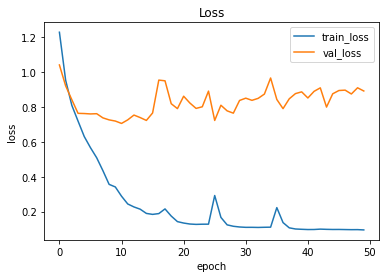

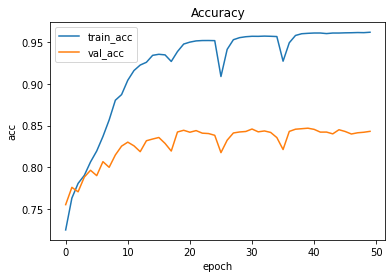

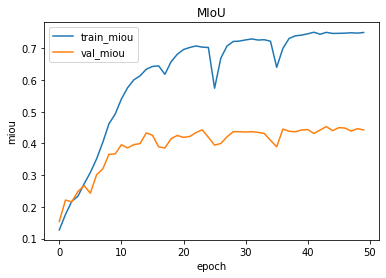

In [25]:
history = {'train_loss': train_loss_list, 'val_loss':val_loss_list,'train_miou': train_iou_list,
'val_miou':val_iou_list,'train_acc':train_acc_list,'val_acc':val_acc_list,'lr':lrs}
def plot_loss(history):
    plt.plot(history['train_loss'], label='train_loss')
    plt.plot(history['val_loss'], label='val_loss')
    plt.title('Loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def plot_miou(history):
    plt.plot(history['train_miou'], label='train_miou')
    plt.plot(history['val_miou'], label='val_miou')
    plt.title('MIoU')
    plt.xlabel('epoch')
    plt.ylabel('miou')
    plt.legend()
    plt.show()

def plot_acc(history):
    plt.plot(history['train_acc'], label='train_acc')
    plt.plot(history['val_acc'], label='val_acc')
    plt.title('Accuracy')
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.legend()
    plt.show()
plot_loss(history)
plot_acc(history)
plot_miou(history)

In [26]:
best=torch.load('./models/FCN32-Vgg16_test.pt')

In [27]:
def decode_segmap(image, num_class=21):
    label_color = np.array([(0, 0, 0),
               (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128), (128, 0, 128),
               (0, 128, 128), (128, 128, 128), (64, 0, 0), (192, 0, 0), (64, 128, 0),
               (192, 128, 0), (64, 0, 128), (192, 0, 128), (64, 128, 128), (192, 128, 128),
               (0, 64, 0), (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, num_class):
        idx = image==l
        r[idx] = label_color[l,0]
        g[idx] = label_color[l,1]
        b[idx] = label_color[l,2]
    rgb =np.stack([r,g,b], axis=2)
    return rgb

(224, 224)


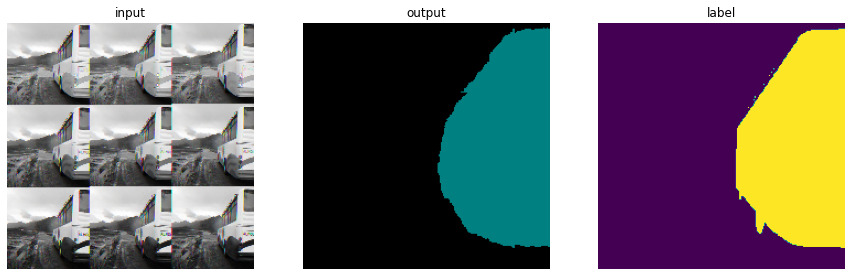

In [29]:
#img, label= train_set[0]
best.eval()
with torch.no_grad():
    for i, data in enumerate(train_loader):
        img, label = data
        
        best.to(device)
        #print(f'input shape:',img.shape)
        img = img.to(device)
        output = best(img)

        # tensor의 추적 제거 detach
        pred = torch.argmax(output[0], dim=0).detach().cpu().numpy()
        print(pred.shape)
        pred = decode_segmap(pred,21)
        
        img = img.squeeze() * torch.tensor(data_std).view(3, 1, 1).to(device)
        img = img + torch.tensor(data_mean).view(3, 1, 1).to(device)
        img = img[0].detach().cpu().numpy()
        img = img.reshape(img.shape[1], img.shape[2], img.shape[0])

        label = label.numpy()
        #label = decode_segmap(label[0],21)
        
        plt.figure(figsize=(15,10))
        plt.subplot(1,3,1)
        plt.title('input')
        plt.axis('off')
        plt.imshow(img)
        plt.subplot(1,3,2)
        plt.title('output')
        plt.axis('off')
        plt.imshow(pred)
        plt.subplot(1,3,3)
        plt.title('label')
        plt.axis('off')
        plt.imshow(label[0])
        break
